Input:
- True Observations
- Number Training Steps

Output:
- New Model Parameter

Parts of Optimization:
- Initialization of Model Parameter
- tbd

# Initialization

## Import Libraries and Mount Drive

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import torch
from torch import distributions, optim

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GitHub/master-thesis

import sys
sys.path.append('/content/gdrive/My Drive/GitHub/master-thesis')

from model.modelcore import epid_model
from model.modelhelper import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GitHub/master-thesis


## Optimization Settings

In [3]:
start_time='2020-02-26'
end_time='2020-09-30'
observations=['Confirmed_cases', 'Admissions_hospital'] # ['Number_of_deaths', 'Confirmed_cases', 'Admissions_hospital']

dtype = torch.float32
device = torch.device("cuda:0") #cuda:0

## Initialize Observations

In [4]:
df_obs_initial = pd.read_csv('data/observations_03022022.csv' , sep=';', thousands='.', decimal=',', encoding='utf-8', parse_dates=['Date'])
df_obs = initialize_observations(df_obs_initial, start=start_time, end=end_time, observations=observations)
observed = torch.tensor(df_obs['Confirmed_cases'], requires_grad=False, device=device, dtype=dtype)
df_obs.head(3)

,Date,Confirmed_cases,Admissions_hospital
0,2020-02-26,1,0
1,2020-02-27,1,0
2,2020-02-28,1,0


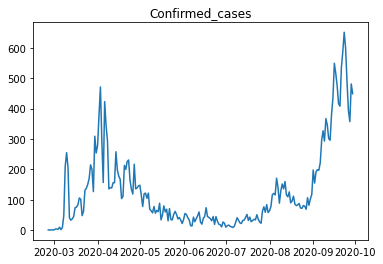

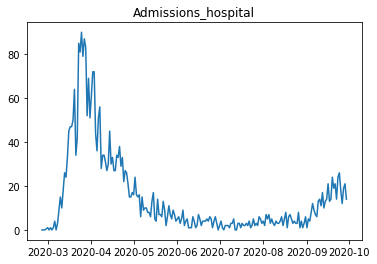

In [5]:
for observation in observations:
  plt.plot(df_obs['Date'], df_obs[observation])
  plt.title(observation)
  plt.show()

## Initialize Model Parameter

### Initialize Helper Parameter

In [6]:
cero = torch.tensor(0., requires_grad=False, device=device, dtype=dtype)
num_observations = df_obs.shape[0]
population = torch.tensor(5793636, requires_grad=False, device=device, dtype=dtype)

### Initialize to be optimized Model Parameter

In [ ]:
thisdict = {
  "brand": "Ford",
  "model": "Mustang",
  "year": 1964
}
thisdict["color"] = "red"
print(thisdict)

In [ ]:
parameter = ['R0', 'alpha', 'sigma', 'phi']
dict_parameter = {'prime_values':{}, 'real_values': {}}
for param in parameter:
  dict_parameter['prime_values'][param + '_prime'] = initialize_prime_param(param, device, dtype)
  dict_parameter['real_values'][param] = 



dict_parameter = {'prime_values': {'R0_prime': R0_prime, 'phi_prime': phi_prime, 'sigma_prime': sigma_prime, 'alpha_prime': alpha_prime},
                  'real_values': {'R0': R0, 'phi': phi, 'sigma': sigma, 'alpha': alpha}}

In [ ]:
dict_parameter = {'prime_values': {'R0_prime': R0_prime, 'phi_prime': phi_prime, 'sigma_prime': sigma_prime, 'alpha_prime': alpha_prime},
                  'real_values': {'R0': R0, 'phi': phi, 'sigma': sigma, 'alpha': alpha}}

In [7]:
R0_prime = initialize_prime_param('R0', device, dtype)
phi_prime = initialize_prime_param('phi', device, dtype)
sigma_prime = initialize_prime_param('sigma', device, dtype)
alpha_prime = initialize_prime_param('alpha', device, dtype)

In [8]:
dict_model_param = get_dict_model_param()
sigma_lower = dict_model_param['lower']['sigma']
sigma_upper= dict_model_param['upper']['sigma']

sigma = bij_transform(sigma_prime, sigma_lower, sigma_upper)

alpha_lower = dict_model_param['lower']['alpha']
alpha_upper= dict_model_param['upper']['alpha']

In [9]:
epsilon_t = initialize_epsilon(num_observations, sigma, dtype=dtype, device=device)

NameError: ignored

In [16]:
prime_parameter = ['R0_prime', 'alpha_prime']
def transform_prime_variables(prime_parameter=[]):
  for prime in prime_parameter:
    real_value = prime[:-6]
    dict_parameter['real_values'][real_value] = bij_transform(prime, dict_model_param['lower'][real_value], dict_model_param['upper'][real_value])


R0
alpha


# Optimization

In [ ]:
def transform_variables(R0_prime, sigma_prime, phi_prime, alpha_prime):
    R0 = bij_transform(R0_prime, lower=2, upper=5)
    sigma = bij_transform(sigma_prime, lower=0.01, upper=0.5)
    phi = bij_transform(phi_prime, lower=0.00001, upper=50)
    alpha = bij_transform(alpha_prime, lower=0.001, upper=0.05)
    return R0, sigma, phi, alpha

In [ ]:
def calc_prior_loss(R0, sigma, phi, alpha, device, dtpye): # To Do - use for loop - flexible input parameter
  """Takes R0, sigma, phi and alpha as an input and calculates the prior loss.
  The prior loss is calculated by using the log-probability."""

  ll = torch.tensor(0.0, device=device, dtype=dtype)

  ll += distributions.normal.Normal(loc=torch.tensor(dict_model_param['value']['R0'], device=device, dtype=dtype), scale=torch.tensor(dict_model_param['scale']['R0'], device=device, dtype=dtype)).log_prob(R0)[0] # neg

  ll += distributions.normal.Normal(loc=torch.tensor(dict_model_param['value']['sigma'], device=device, dtype=dtype), scale=torch.tensor(dict_model_param['scale']['sigma'], device=device, dtype=dtype)).log_prob(sigma)[0]

  ll += distributions.normal.Normal(loc=torch.tensor(dict_model_param['value']['phi'], device=device, dtype=dtype), scale=torch.tensor(dict_model_param['scale']['phi'], device=device, dtype=dtype)).log_prob(phi)[0]

  ll += distributions.normal.Normal(loc=torch.tensor(dict_model_param['value']['alpha'], device=device, dtype=dtype), scale=torch.tensor(dict_model_param['scale']['alpha'], device=device, dtype=dtype)).log_prob(alpha)[0]

  return -ll

## Training

Step: 0, Time: 0.3875465393066406, Loss: 926.8685913085938, Mean Expected Daily Hospit: 127.15943908691406


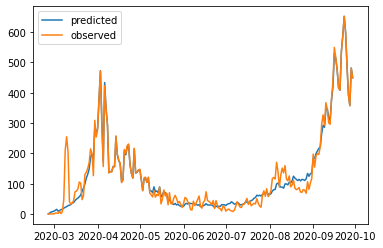

Step: 5, Time: 0.3964836597442627, Loss: 1204.9840087890625, Mean Expected Daily Hospit: 136.85487365722656
Step: 10, Time: 0.3783450126647949, Loss: 927.3226928710938, Mean Expected Daily Hospit: 124.27967834472656
Step: 15, Time: 0.38234591484069824, Loss: 890.49365234375, Mean Expected Daily Hospit: 126.08877563476562
Step: 20, Time: 0.37467312812805176, Loss: 892.6591796875, Mean Expected Daily Hospit: 128.89804077148438


KeyboardInterrupt: ignored

In [11]:
epochs = 1000
params = [epsilon_t, alpha_prime, phi_prime, sigma_prime]

optimizer = optim.Adam(params, lr=0.01, weight_decay=1e-8)

for i in range(epochs):
  start_time = time.time()
  optimizer.zero_grad()

  # forward pass
  alpha = bij_transform(alpha_prime, alpha_lower, alpha_upper)
  expected = epid_model(population, R=torch.abs(epsilon_t), initial_newly_infected=np.arange(1, 18, 3), alpha=alpha, device=device, dtype=dtype)['newly_infected']

  # calc loss
  comp_loss = calc_mse(expected, observed)
  prior_loss = calc_prior_loss(R0, sigma, phi, alpha)
  rw_loss = calc_random_walk_loss(epsilon_t, sigma, training_days)
  loss = phi*comp_loss + prior_loss +rw_loss

  # backward pass
  loss.backward()
  optimizer.step()

  if i % 5==0:
      print(f'Step: {i}, Time: {time.time() - start_time}, Loss: {loss}, Mean Expected Daily Hospit: {expected.cpu().detach().numpy().mean()}')
  
  if i % 50==0:
    plt.plot(df_obs['Date'], expected.cpu().detach().numpy(), label='predicted')
    plt.plot(df_obs['Date'], observed.cpu().detach().numpy(), label='observed')
    plt.legend()
    plt.show()


# Evaluation

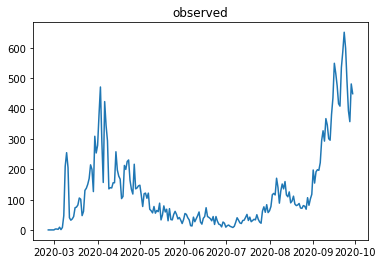

In [12]:
plt.plot(df_obs['Date'], observed.cpu().detach().numpy())
plt.title('observed')
plt.show()

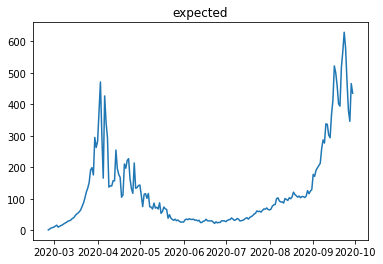

In [13]:
plt.plot(df_obs['Date'], expected.cpu().detach().numpy())
plt.title('expected')
plt.show()